In [1]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

In [2]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
# a @ b is equivalent to np.matmul(a, b)
c_mm_relu = np.maximum(a_np @ b_np, 0)

### a lower level numpy


In [3]:
def lnumpy_mm_relu(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j in range(128):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

In [4]:
c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

In [5]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"],
                B: T.Buffer[(128, 128), "float32"],
                C: T.Buffer[(128, 128), "float32"]):
        T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
        Y = T.alloc_buffer((128, 128), dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                vk = T.axis.reduce(128, k)
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [6]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j0 in range(32):
            for k in range(128):
                for j1 in range(4):
                    j = j0 * 4 + j1
                    if k == 0:
                        Y[i, j] = 0
                    Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu_v2(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

In [7]:
import IPython

IPython.display.Code(MyModule.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [8]:
sch = tvm.tir.Schedule(MyModule)

In [9]:
block_Y = sch.get_block("Y", func_name="mm_relu")
i, j, k = sch.get_loops(block_Y)

In [10]:
j0, j1 = sch.split(j, factors=[None, 4])

In [11]:
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0, j_1, k in T.grid(128, 32, 4, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j_0 * 4 + j_1)
                vk = T.axis.reduce(128, k)
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [12]:
sch.reorder(j0, k, j1)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0, k, j_1 in T.grid(128, 32, 128, 4):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j_0 * 4 + j_1)
                vk = T.axis.reduce(128, k)
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

## 算子融合

In [13]:
block_C = sch.get_block("C", "mm_relu")
sch.reverse_compute_at(block_C, j0)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0 in T.grid(128, 32):
            for k, j_1 in T.grid(128, 4):
                with T.block("Y"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(A[vi, vk], B[vk, vj])
                    T.writes(Y[vi, vj])
                    with T.init():
                        Y[vi, vj] = T.float32(0)
                    Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
            for ax0 in T.serial(4):
                with T.block("C"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + ax0)
                    T.reads(Y[vi, vj])
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [14]:
sch.decompose_reduction(block_Y, k)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0 in T.grid(128, 32):
            for j_1_init in T.serial(4):
                with T.block("Y_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1_init)
                    T.reads()
                    T.writes(Y[vi, vj])
                    Y[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 4):
                with T.block("Y_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(Y[vi, vj], A[vi, vk], B[vk, vj])
                    T.writes(Y[vi, vj])
                    Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
            for ax0 in T.serial(4):
                with T.block("C"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + ax0)
                    T.reads(Y[vi, vj])
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [15]:
rt_lib = tvm.build(MyModule, target="llvm")

[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

In [16]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")
type(c_nd)

tvm.runtime.ndarray.NDArray

In [17]:
func_mm_relu = rt_lib["mm_relu"]
func_mm_relu(a_nd, b_nd, c_nd)

np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

In [18]:
rt_lib_after = tvm.build(sch.mod, target="llvm")
rt_lib_after["mm_relu"](a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

In [19]:
f_timer_before = rt_lib.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of MyModule %g sec" % f_timer_before(a_nd, b_nd, c_nd).mean)
f_timer_after = rt_lib_after.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of transformed sch.mod %g sec" % f_timer_after(a_nd, b_nd, c_nd).mean)

Time cost of MyModule 0.00257632 sec
Time cost of transformed sch.mod 0.000433733 sec


In [20]:
def transform(mod, jfactor):
    sch = tvm.tir.Schedule(mod)
    block_Y = sch.get_block("Y", func_name="mm_relu")
    i, j, k = sch.get_loops(block_Y)
    j0, j1 = sch.split(j, factors=[None, jfactor])
    sch.reorder(j0, k, j1)
    block_C = sch.get_block("C", "mm_relu")
    sch.reverse_compute_at(block_C, j0)
    return sch.mod

def jfactor_test(j):
    mod_transformed = transform(MyModule, jfactor=j)

    rt_lib_transformed = tvm.build(mod_transformed, "llvm")
    f_timer_transformed = rt_lib_transformed.time_evaluator("mm_relu", tvm.cpu())
    print("Time cost of transformed mod_transformed %g sec" % f_timer_transformed(a_nd, b_nd, c_nd).mean)
    # display the code below
    # print(f_timer_transformed(a_nd, b_nd, c_nd).mean)
    IPython.display.Code(mod_transformed.script(), language="python")
    return f_timer_transformed(a_nd, b_nd, c_nd).mean

In [21]:
result = []
xpoints = []
for j in range(1,200):
    xpoints.append(j)
    result.append(jfactor_test(j))
print(result)

[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00396926 sec
Time cost of transformed mod_transformed 0.000764383 sec


[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000585567 sec
Time cost of transformed mod_transformed 0.0004035 sec
Time cost of transformed mod_transformed 0.000444829 sec


[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000355079 sec
Time cost of transformed mod_transformed 0.000377329 sec
Time cost of transformed mod_transformed 0.000202296 sec


[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000382546 sec
Time cost of transformed mod_transformed 0.000238179 sec
Time cost of transformed mod_transformed 0.000236517 sec


[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000213362 sec
Time cost of transformed mod_transformed 0.000209196 sec
Time cost of transformed mod_transformed 0.000223042 sec


[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:25] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000248883 sec
Time cost of transformed mod_transformed 0.000272312 sec
Time cost of transformed mod_transformed 0.000242612 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000225383 sec
Time cost of transformed mod_transformed 0.000188592 sec
Time cost of transformed mod_transformed 0.00015785 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000429512 sec
Time cost of transformed mod_transformed 0.000147192 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000357887 sec
Time cost of transformed mod_transformed 0.000343004 sec
Time cost of transformed mod_transformed 0.000664567 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00116107 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000560142 sec
Time cost of transformed mod_transformed 0.00115843 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0011364 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00129969 sec
Time cost of transformed mod_transformed 0.00108079 sec
Time cost of transformed mod_transformed 0.000233496 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00102376 sec


[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:26] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00109455 sec
Time cost of transformed mod_transformed 0.00113235 sec
Time cost of transformed mod_transformed 0.00116364 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00125661 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00130147 sec
Time cost of transformed mod_transformed 0.00133628 sec
Time cost of transformed mod_transformed 0.00137894 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00112164 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00140876 sec
Time cost of transformed mod_transformed 0.000952812 sec
Time cost of transformed mod_transformed 0.001025 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00110757 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00111837 sec
Time cost of transformed mod_transformed 0.00111963 sec
Time cost of transformed mod_transformed 0.0011535 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00120387 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00124039 sec
Time cost of transformed mod_transformed 0.00126629 sec
Time cost of transformed mod_transformed 0.0012723 sec


[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:27] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00134829 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00135412 sec
Time cost of transformed mod_transformed 0.00146235 sec
Time cost of transformed mod_transformed 0.00143395 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00157004 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00160248 sec
Time cost of transformed mod_transformed 0.00156096 sec
Time cost of transformed mod_transformed 0.00172753 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00129139 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0018358 sec
Time cost of transformed mod_transformed 0.00141825 sec
Time cost of transformed mod_transformed 6.06708e-05 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.000949738 sec
Time cost of transformed mod_transformed 0.00108476 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00116657 sec
Time cost of transformed mod_transformed 0.00114622 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00109963 sec
Time cost of transformed mod_transformed 0.00111992 sec


[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:28] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00123867 sec
Time cost of transformed mod_transformed 0.00127699 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00126701 sec
Time cost of transformed mod_transformed 0.00118746 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00122156 sec
Time cost of transformed mod_transformed 0.00134033 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00138219 sec
Time cost of transformed mod_transformed 0.00136413 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0013268 sec
Time cost of transformed mod_transformed 0.00134647 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00143504 sec
Time cost of transformed mod_transformed 0.00143872 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.001565 sec
Time cost of transformed mod_transformed 0.00141565 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00145305 sec
Time cost of transformed mod_transformed 0.00156381 sec


[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:29] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00156258 sec
Time cost of transformed mod_transformed 0.00159114 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00155523 sec
Time cost of transformed mod_transformed 0.00159694 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00173058 sec
Time cost of transformed mod_transformed 0.00173668 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00182443 sec
Time cost of transformed mod_transformed 0.00181912 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00174004 sec
Time cost of transformed mod_transformed 0.00174942 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00188624 sec
Time cost of transformed mod_transformed 0.00191711 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00191399 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00195893 sec
Time cost of transformed mod_transformed 0.00198182 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00197266 sec


[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:30] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00199977 sec
Time cost of transformed mod_transformed 0.00200137 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0020677 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00222511 sec
Time cost of transformed mod_transformed 0.0021026 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00219859 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00215983 sec
Time cost of transformed mod_transformed 0.00218345 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00218695 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0022314 sec
Time cost of transformed mod_transformed 0.0022544 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00236632 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0023255 sec
Time cost of transformed mod_transformed 0.00229737 sec


[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:31] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00233851 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00236147 sec
Time cost of transformed mod_transformed 0.0023845 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00245018 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00173339 sec
Time cost of transformed mod_transformed 0.00244834 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00176012 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00247247 sec
Time cost of transformed mod_transformed 0.00177757 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00252455 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00185217 sec
Time cost of transformed mod_transformed 0.000160054 sec
Time cost of transformed mod_transformed 0.000151521 sec


[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:32] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00109783 sec
Time cost of transformed mod_transformed 0.00109642 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00111253 sec
Time cost of transformed mod_transformed 0.00115838 sec
Time cost of transformed mod_transformed 0.00119535 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00121153 sec
Time cost of transformed mod_transformed 0.00122822 sec
Time cost of transformed mod_transformed 0.00130128 sec
Time cost of transformed mod_transformed 0.00129288 sec
Time cost of transformed mod_transformed 0.00130141 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00130328 sec
Time cost of transformed mod_transformed 0.00127625 sec
Time cost of transformed mod_transformed 0.00127189 sec
Time cost of transformed mod_transformed 0.0013174 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00133739 sec
Time cost of transformed mod_transformed 0.00146363 sec
Time cost of transformed mod_transformed 0.00132876 sec
Time cost of transformed mod_transformed 0.00135187 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0013501 sec
Time cost of transformed mod_transformed 0.00135183 sec
Time cost of transformed mod_transformed 0.00133915 sec
Time cost of transformed mod_transformed 0.00137211 sec


[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:33] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00140513 sec
Time cost of transformed mod_transformed 0.00141634 sec
Time cost of transformed mod_transformed 0.00142066 sec
Time cost of transformed mod_transformed 0.00144539 sec


[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00145049 sec
Time cost of transformed mod_transformed 0.00143188 sec
Time cost of transformed mod_transformed 0.00144212 sec
Time cost of transformed mod_transformed 0.00146107 sec


[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00147317 sec
Time cost of transformed mod_transformed 0.00147853 sec
Time cost of transformed mod_transformed 0.00150457 sec
Time cost of transformed mod_transformed 0.00152852 sec


[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00153283 sec
Time cost of transformed mod_transformed 0.00151021 sec
Time cost of transformed mod_transformed 0.00151156 sec
Time cost of transformed mod_transformed 0.00155434 sec


[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:34] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00158971 sec
Time cost of transformed mod_transformed 0.00154139 sec
Time cost of transformed mod_transformed 0.00155847 sec
Time cost of transformed mod_transformed 0.00159655 sec


[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00162214 sec
Time cost of transformed mod_transformed 0.00161805 sec
Time cost of transformed mod_transformed 0.00160793 sec
Time cost of transformed mod_transformed 0.00180529 sec


[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00168317 sec
Time cost of transformed mod_transformed 0.00162159 sec
Time cost of transformed mod_transformed 0.00171628 sec
Time cost of transformed mod_transformed 0.00174123 sec


[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00176921 sec
Time cost of transformed mod_transformed 0.00177049 sec
Time cost of transformed mod_transformed 0.00182632 sec
Time cost of transformed mod_transformed 0.00177827 sec


[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:35] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0017972 sec
Time cost of transformed mod_transformed 0.00179575 sec
Time cost of transformed mod_transformed 0.00187938 sec
Time cost of transformed mod_transformed 0.00185628 sec


[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00186163 sec
Time cost of transformed mod_transformed 0.00186047 sec
Time cost of transformed mod_transformed 0.001871 sec
Time cost of transformed mod_transformed 0.00189394 sec


[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00191659 sec
Time cost of transformed mod_transformed 0.00190848 sec
Time cost of transformed mod_transformed 0.00192953 sec
Time cost of transformed mod_transformed 0.00196649 sec


[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.0019812 sec
Time cost of transformed mod_transformed 0.00193875 sec


[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

Time cost of transformed mod_transformed 0.00199631 sec
Time cost of transformed mod_transformed 0.0025876 sec
[0.0039829, 0.0007871625000000001, 0.0005803334000000001, 0.00042039160000000004, 0.00042224159999999995, 0.0003574083, 0.0003892334, 0.00019750000000000003, 0.00038491670000000003, 0.0002476584, 0.0002375667, 0.0002104042, 0.00021065420000000002, 0.00022201669999999998, 0.0002534292, 0.00027539999999999997, 0.0002443625, 0.00022114999999999998, 0.0001822375, 0.000166, 0.00045072919999999993, 0.000136075, 0.00035085829999999995, 0.0003489334, 0.0006732416, 0.0010526583, 0.0005813208, 0.0011860625, 0.0011644416, 0.0013248291, 0.0011008125, 0.00023277079999999998, 0.0010167959, 0.0010839166, 0.001131775, 0.0011631624999999999, 0.0012588167, 0.0012887792, 0.0013308959, 0.0013786375, 0.00111495, 0.0014288209, 0.0009561833000000001, 0.0010178791999999998, 0.0010801875, 0.0011218417000000002, 0.0011430292, 0.0011768792, 0.0012525083000000002, 0.0012373375, 0.0012702333, 0.0012730250

[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: Warning: cannot evaluate set type tir.Call
[10:02:36] /Users/yd/Documents/tvm/src/arith/int_set.cc:521: War

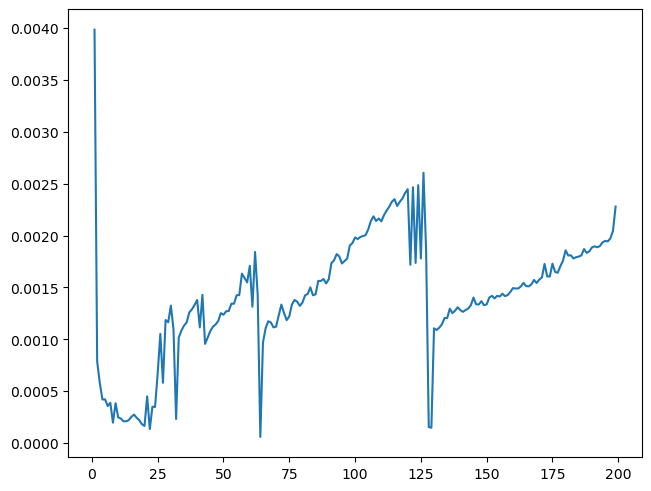

In [22]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(16, 12))
fig, ax0 = plt.subplots(1, 1, sharex=True, constrained_layout=True)
# fig.figsize(15, 15)
ax0.plot(xpoints, result)

# plt.show()
